In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import learning_curve
warnings.filterwarnings('ignore')
from sklearn import datasets
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc
from sklearn.model_selection import cross_val_score

In [2]:
iris_df = datasets.load_iris(as_frame=True)
features=iris_df.feature_names
df=pd.DataFrame(iris_df.data)
df['target']=iris_df.target
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


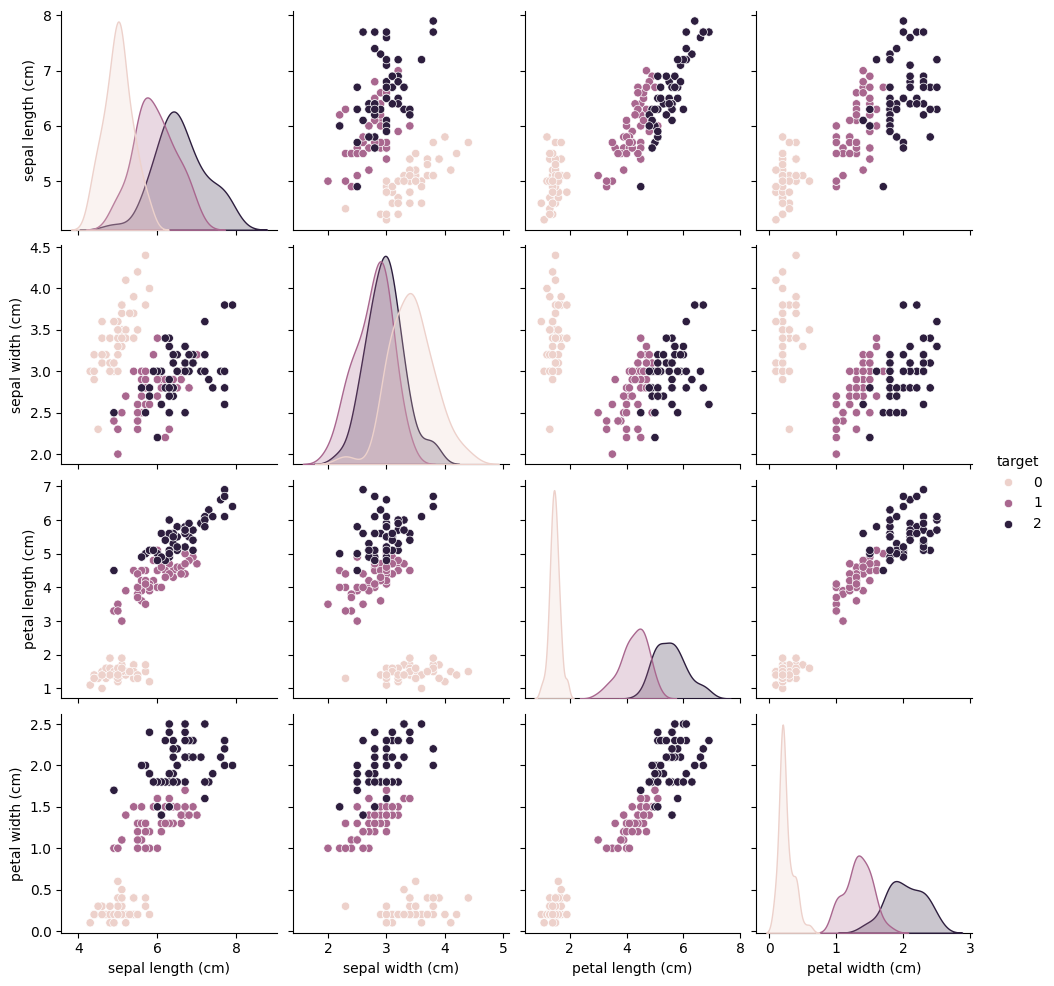

In [3]:
#visualization
sns.pairplot(df,hue='target')

In [4]:
df['target'].value_counts()

,count
target,
0,50
1,50
2,50


In [5]:
df.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'target'],
      dtype='object')

<Axes: xlabel='petal length (cm)', ylabel='petal width (cm)'>

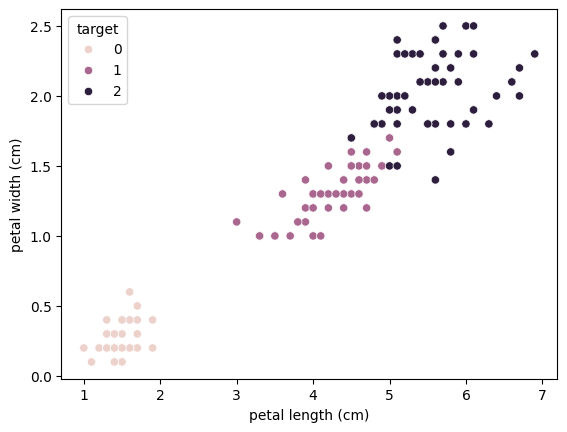

In [6]:
sns.scatterplot(data=df,x='petal length (cm)',y='petal width (cm)', hue='target')

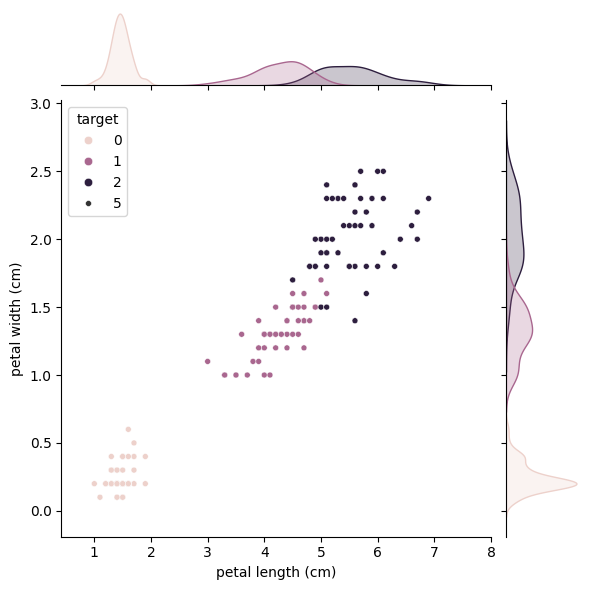

In [7]:
sns.jointplot(x="petal length (cm)", y="petal width (cm)",hue='target', data=df, size=5)

<Axes: >

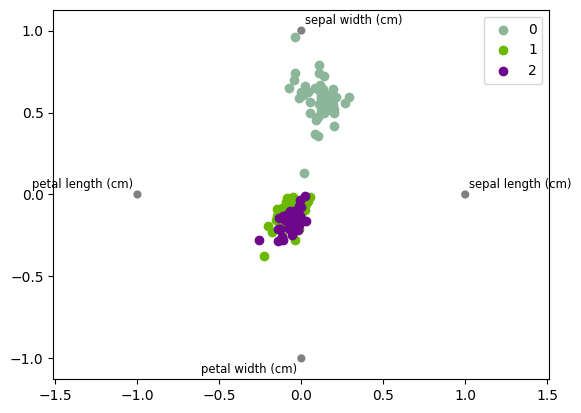

In [8]:
from pandas.plotting import radviz
radviz(df, "target")

## SVM Classifier

In [9]:
#split data into train test
x= df.iloc[:, :-1]
y= df.iloc[:, -1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [10]:
#Random Forest Classifier
svc_clf= SVC(kernel='linear')
svc_clf.fit(x_train, y_train)

svc_y_pred= svc_clf.predict(x_test)
accuracy_score(y_test, svc_y_pred)

1.0

<Axes: >

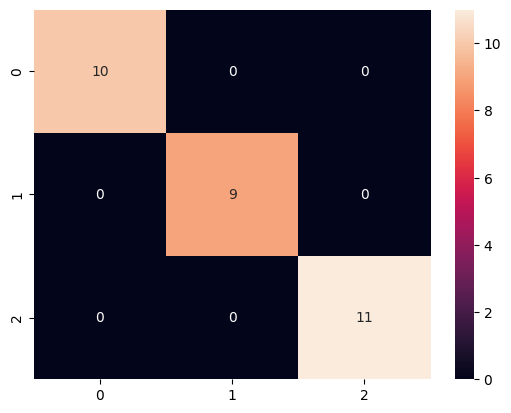

In [11]:
sns.heatmap(confusion_matrix(y_test, svc_y_pred), annot=True)

In [12]:
print(classification_report(y_test, svc_y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



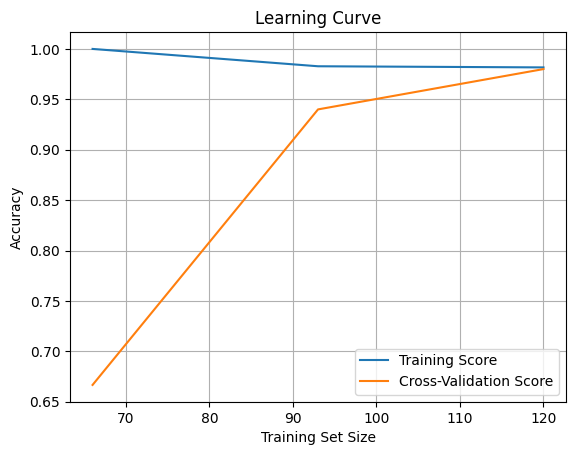

In [13]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    svc_clf, x, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Cross-Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve')
plt.grid()
plt.show()


In [14]:
y_train_pred= svc_clf.predict(x_train)
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, svc_y_pred)

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Test Accuracy:  {test_acc:.2f}")

Train Accuracy: 0.97
Test Accuracy:  1.00


In [15]:
scores = cross_val_score(svc_clf, x, y, cv=5)
print("CV scores:", scores)
print("Mean CV accuracy:", scores.mean())

CV scores: [0.96666667 1.         0.96666667 0.96666667 1.        ]
Mean CV accuracy: 0.9800000000000001


#### Build SVM from Scratch

In [16]:
class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize weights and bias
        self.w = np.zeros(n_features)
        self.b = 0

        # Gradient descent
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.w) + self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y[idx]))
                    self.b -= self.lr * y[idx]

    def predict(self, X):
        approx = np.dot(X, self.w) + self.b
        return np.sign(approx)


class MultiClassSVM:
    def __init__(self, **kwargs):
        self.models = {}
        self.kwargs = kwargs

    def fit(self, X, y):
        self.classes = np.unique(y)
        for cls in self.classes:
            y_binary = np.where(y == cls, 1, -1)
            model = SVM(**self.kwargs)
            model.fit(X, y_binary)
            self.models[cls] = model

    def predict(self, X):
        scores = {}
        for cls, model in self.models.items():
            scores[cls] = np.dot(X, model.w) + model.b
        scores = np.array(list(scores.values()))
        return self.classes[np.argmax(scores, axis=0)]


In [17]:
X1= df.iloc[:, :-1].values
Y1= df.iloc[:, -1].values.reshape(-1,1)
x_train_1, x_test_1, y_train_1, y_test_1= train_test_split(X1, Y1, test_size=0.2, random_state=42)

In [18]:
svm = MultiClassSVM(learning_rate=0.001, lambda_param=0.01, n_iters=1000)
temp_y_train_1= np.squeeze(np.asarray(y_train_1))
svm.fit(x_train_1, temp_y_train_1)

In [19]:
svm_predictions = svm.predict(x_test_1)

In [21]:
svm_scratch_accuracy= accuracy_score(y_test_1, svm_predictions)
print('Accuracy',svm_scratch_accuracy)
print(classification_report(y_test_1, svm_predictions))

Accuracy 0.8666666666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.86      0.67      0.75         9
           2       0.77      0.91      0.83        11

    accuracy                           0.87        30
   macro avg       0.88      0.86      0.86        30
weighted avg       0.87      0.87      0.86        30

